Refrensi :
1. https://www.kaggle.com/code/chinmayadatt/obesity-risk-prediction-multi-class-0-92160#notebook-container

# Library Needed

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#load General Packages
import pandas as pd
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}". format(np.__version__))
import IPython
from IPython import display
print("IPython version: {}". format(IPython.__version__))
import sklearn
print("scikit-learn version: {}". format(sklearn.__version__))
import random
import time
from IPython.display import display
import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

pandas version: 1.5.3
matplotlib version: 3.7.1
NumPy version: 1.25.2
IPython version: 7.34.0
scikit-learn version: 1.2.2


In [7]:
def basic_data_info(dataframe):
    """
    Menampilkan informasi dasar dari DataFrame.
    """
    # Menampilkan lima baris pertama DataFrame
    print("Preview Data:")
    print("---------------------------")
    display(dataframe.head())

    # Menampilkan info umum DataFrame
    print("\nInformasi Umum:")
    print("---------------------------")
    print(dataframe.info())

    # Menampilkan statistik deskriptif
    print("\nStatistik Deskriptif:")
    print("---------------------------")
    display(dataframe.describe())

In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [9]:
def check_duplicates(dataframe):
    """
    Memeriksa nilai duplikat dari DataFrame.
    """
    # Menampilkan nilai duplikat
    print("Nilai Duplikat (10 Teratas):")
    duplicate_values = dataframe[dataframe.duplicated()]
    print(f"Jumlah Duplikat data: {duplicate_values.shape[0]}")
    display(duplicate_values.head(10))

In [10]:
!pip install category_encoders optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [46]:
import tensorflow as tf
import os
import optuna

from sklearn.svm import SVC  # SVM untuk klasifikasi
from sklearn.naive_bayes import GaussianNB  # Naive Bayes dengan distribusi Gaussian
from sklearn.tree import DecisionTreeClassifier  # Decision Tree untuk klasifikasi

from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn import set_config

from sklearn.pipeline import make_pipeline, Pipeline, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedGroupKFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin, clone

In [12]:
os.environ['PYTHONHASHSEED'] = '51'
random.seed(89)

# Set Prameters for Reproduciblity
TARGET = "NObeyesdad"
n_splits = 9
RANDOM_SEED = 73

# Import Data

In [100]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Final Project [Enrollment]/ObesityDataSet.csv")

## Metadata

| Column                         | Full Form                        | Description                                                                 |
|:--------------------------------:|----------------------------------|-----------------------------------------------------------------------------|
| 'id'                           | id                               | Unique for each person(row)                                                |
| 'Gender'                       | Gender                           | Person's Gender                                                             |
| 'Age'                          | Age                              | Dtype is float. Age is between 14 years to 61 years                         |
| 'Height'                       | Height                           | Height is in meter it's between 1.45m to 1.98m                              |
| 'Weight'                       | Weight                           | Weight is between 39 to 165. I think it's in KG.                            |
| 'family_history_with_overweight' | Family history with overweight | Yes or no question                                                          |
| 'FAVC'                         | Frequent consumption of high calorie food | Yes or no question, consumption of high calorie food                      |
| 'FCVC'                         | Frequency of consumption of vegetables | Yes or no question, frequency of consumption of vegetables               |
| 'NCP'                          | Number of main meals            | Dtype is float, NCP is between 1 & 4. Synthetic data may have float values |
| 'CAEC'                         | Consumption of food between meals | Takes 4 values: Sometimes, Frequently, No, Always                          |
| 'SMOKE'                        | Smoke                            | Yes or no question, "Do you smoke?"                                         |
| 'CH2O'                         | Consumption of water daily      | Takes values between 1 & 3. Synthetic data may have float values           |
| 'SCC'                          | Calories consumption monitoring | Yes or no question                                                          |
| 'FAF'                          | Physical activity frequency    | Between 0 to 3, 0 means no physical activity and 3 means high workout       |
| 'TUE'                          | Time using technology devices  | Between 0 to 2, "How long you have been using technology devices to track your health" |
| 'CALC'                         | Consumption of alcohol         | Takes 3 values: Sometimes, No, Frequently                                   |
| 'MTRANS'                       | Transportation used            | Takes 5 values: Public_Transportation, Automobile, Walking, Motorbike, Bike |
| 'NObeyesdad'                   | TARGET                           | Target variable, takes 7 values. Class name for classification.             |


> **ANObeyesdad** (*Target Variable*):

1. Insufficient_Weight : Less than 18.5
2. Normal_Weight : 18.5 to 24.9
3. Obesity_Type_I : 30.0 to 34.9
4. Obesity_Type_II : 35.0 to 39.9
5. Obesity_Type_III : Higher than 40
6. Overweight_Level_I : takes values between 25 to 29
7. Overweight_Level_II : takes values between 25 to 29

# Explore the Data

## Basic Information of the dataset

In [101]:
basic_data_info(df)

Preview Data:
---------------------------


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0000,1.6200,64.0000,yes,no,2.0000,3.0000,Sometimes,no,2.0000,no,0.0000,1.0000,no,Public_Transportation,Normal_Weight
1,Female,21.0000,1.5200,56.0000,yes,no,3.0000,3.0000,Sometimes,yes,3.0000,yes,3.0000,0.0000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0000,1.8000,77.0000,yes,no,2.0000,3.0000,Sometimes,no,2.0000,no,2.0000,1.0000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0000,1.8000,87.0000,no,no,3.0000,3.0000,Sometimes,no,2.0000,no,2.0000,0.0000,Frequently,Walking,Overweight_Level_I
4,Male,22.0000,1.7800,89.8000,no,no,2.0000,1.0000,Sometimes,no,2.0000,no,0.0000,0.0000,Sometimes,Public_Transportation,Overweight_Level_II



Informasi Umum:
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   ob

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.0000,2111.0000,2111.0000,2111.0000,2111.0000,2111.0000,2111.0000,2111.0000
mean,24.3126,1.7017,86.5861,2.4190,2.6856,2.0080,1.0103,0.6579
std,6.3460,0.0933,26.1912,0.5339,0.7780,0.6130,0.8506,0.6089
min,14.0000,1.4500,39.0000,1.0000,1.0000,1.0000,0.0000,0.0000
25%,19.9472,1.6300,65.4733,2.0000,2.6587,1.5848,0.1245,0.0000
50%,22.7779,1.7005,83.0000,2.3855,3.0000,2.0000,1.0000,0.6253
75%,26.0000,1.7685,107.4307,3.0000,3.0000,2.4774,1.6667,1.0000
max,61.0000,1.9800,173.0000,3.0000,4.0000,3.0000,3.0000,2.0000


## Missing Value

In [102]:
missing_data(df)

,Total,Percent
Gender,0,0.0000
SMOKE,0,0.0000
MTRANS,0,0.0000
CALC,0,0.0000
TUE,0,0.0000
FAF,0,0.0000
SCC,0,0.0000
CH2O,0,0.0000
CAEC,0,0.0000
Age,0,0.0000


## Duplication Data

In [103]:
check_duplicates(df)

Nilai Duplikat (10 Teratas):
Jumlah Duplikat data: 24


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
98,Female,21.0000,1.5200,42.0000,no,no,3.0000,1.0000,Frequently,no,1.0000,no,0.0000,0.0000,Sometimes,Public_Transportation,Insufficient_Weight
106,Female,25.0000,1.5700,55.0000,no,yes,2.0000,1.0000,Sometimes,no,2.0000,no,2.0000,0.0000,Sometimes,Public_Transportation,Normal_Weight
174,Male,21.0000,1.6200,70.0000,no,yes,2.0000,1.0000,no,no,3.0000,no,1.0000,0.0000,Sometimes,Public_Transportation,Overweight_Level_I
179,Male,21.0000,1.6200,70.0000,no,yes,2.0000,1.0000,no,no,3.0000,no,1.0000,0.0000,Sometimes,Public_Transportation,Overweight_Level_I
184,Male,21.0000,1.6200,70.0000,no,yes,2.0000,1.0000,no,no,3.0000,no,1.0000,0.0000,Sometimes,Public_Transportation,Overweight_Level_I
209,Female,22.0000,1.6900,65.0000,yes,yes,2.0000,3.0000,Sometimes,no,2.0000,no,1.0000,1.0000,Sometimes,Public_Transportation,Normal_Weight
309,Female,16.0000,1.6600,58.0000,no,no,2.0000,1.0000,Sometimes,no,1.0000,no,0.0000,1.0000,no,Walking,Normal_Weight
460,Female,18.0000,1.6200,55.0000,yes,yes,2.0000,3.0000,Frequently,no,1.0000,no,1.0000,1.0000,no,Public_Transportation,Normal_Weight
467,Male,22.0000,1.7400,75.0000,yes,yes,3.0000,3.0000,Frequently,no,1.0000,no,1.0000,0.0000,no,Automobile,Normal_Weight
496,Male,18.0000,1.7200,53.0000,yes,yes,2.0000,3.0000,Sometimes,no,2.0000,no,0.0000,2.0000,Sometimes,Public_Transportation,Insufficient_Weight


In [104]:
df.drop_duplicates(inplace = True)

In [105]:
df.rename(columns={"family_history_with_overweight":"FHWO"}, inplace = True)

In [106]:
df['id'] = range(len(df))

# EDA (Exploratory Data Analysis)

## A little more information about Dataframes

In [107]:
df_copy = df.copy()

tmp = pd.DataFrame(index=df_copy.columns)
tmp['count'] = df_copy.count()
tmp['dtype'] = df_copy.dtypes
tmp['nunique'] = df_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(df_copy))*100
tmp['%null'] = (df_copy.isnull().sum()/len(df_copy))*100
tmp['min'] = df_copy.min()
tmp['max'] = df_copy.max()
tmp

,count,dtype,nunique,%nunique,%null,min,max
Gender,2087,object,2,0.0958,0.0000,Female,Male
Age,2087,float64,1402,67.1778,0.0000,14.0000,61.0000
Height,2087,float64,1574,75.4193,0.0000,1.4500,1.9800
Weight,2087,float64,1525,73.0714,0.0000,39.0000,173.0000
FHWO,2087,object,2,0.0958,0.0000,no,yes
FAVC,2087,object,2,0.0958,0.0000,no,yes
FCVC,2087,float64,810,38.8117,0.0000,1.0000,3.0000
NCP,2087,float64,635,30.4264,0.0000,1.0000,4.0000
CAEC,2087,object,4,0.1917,0.0000,Always,no
SMOKE,2087,object,2,0.0958,0.0000,no,yes


In [108]:
tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
del tmp, df_copy

## Target Distribution with Gender

In [109]:
tmp = pd.DataFrame(df.groupby([TARGET, 'Gender'])['id'].agg('count'))
tmp.columns = ['Count']

In [110]:
tmp

Count
NObeyesdad          Gender       
Insufficient_Weight Female    169
                    Male       98
Normal_Weight       Female    137
                    Male      145
Obesity_Type_I      Female    156
                    Male      195
Obesity_Type_II     Female      2
                    Male      295
Obesity_Type_III    Female    323
                    Male        1
Overweight_Level_I  Female    145
                    Male      131
Overweight_Level_II Female    103
                    Male      187

## Full Form of the name columne

In [111]:
# Mengambil kolom-kolom numerik
raw_num_cols = list(df.select_dtypes(include=["int", "float"]).columns)

# Mengambil kolom-kolom kategorikal
raw_cat_cols = list(df.columns.drop(raw_num_cols + [TARGET]))

full_form = dict({'FAVC' : "Frequent consumption of high caloric food",
                  'FCVC' : "Frequency of consumption of vegetables",
                  'NCP' :"Number of main meal",
                  'CAEC': "Consumption of food between meals",
                  'CH2O': "Consumption of water daily",
                  'SCC':  "Calories consumption monitoring",
                  'FAF': "Physical activity frequency",
                  'TUE': "Time using technology devices",
                  'CALC': "Consumption of alcohol" ,
                  'MTRANS' : "Transportation used"})

In [112]:
raw_cat_cols

['Gender', 'FHWO', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

In [113]:
raw_num_cols

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'id']

# Data Visualization

# Individual Numerical Plots

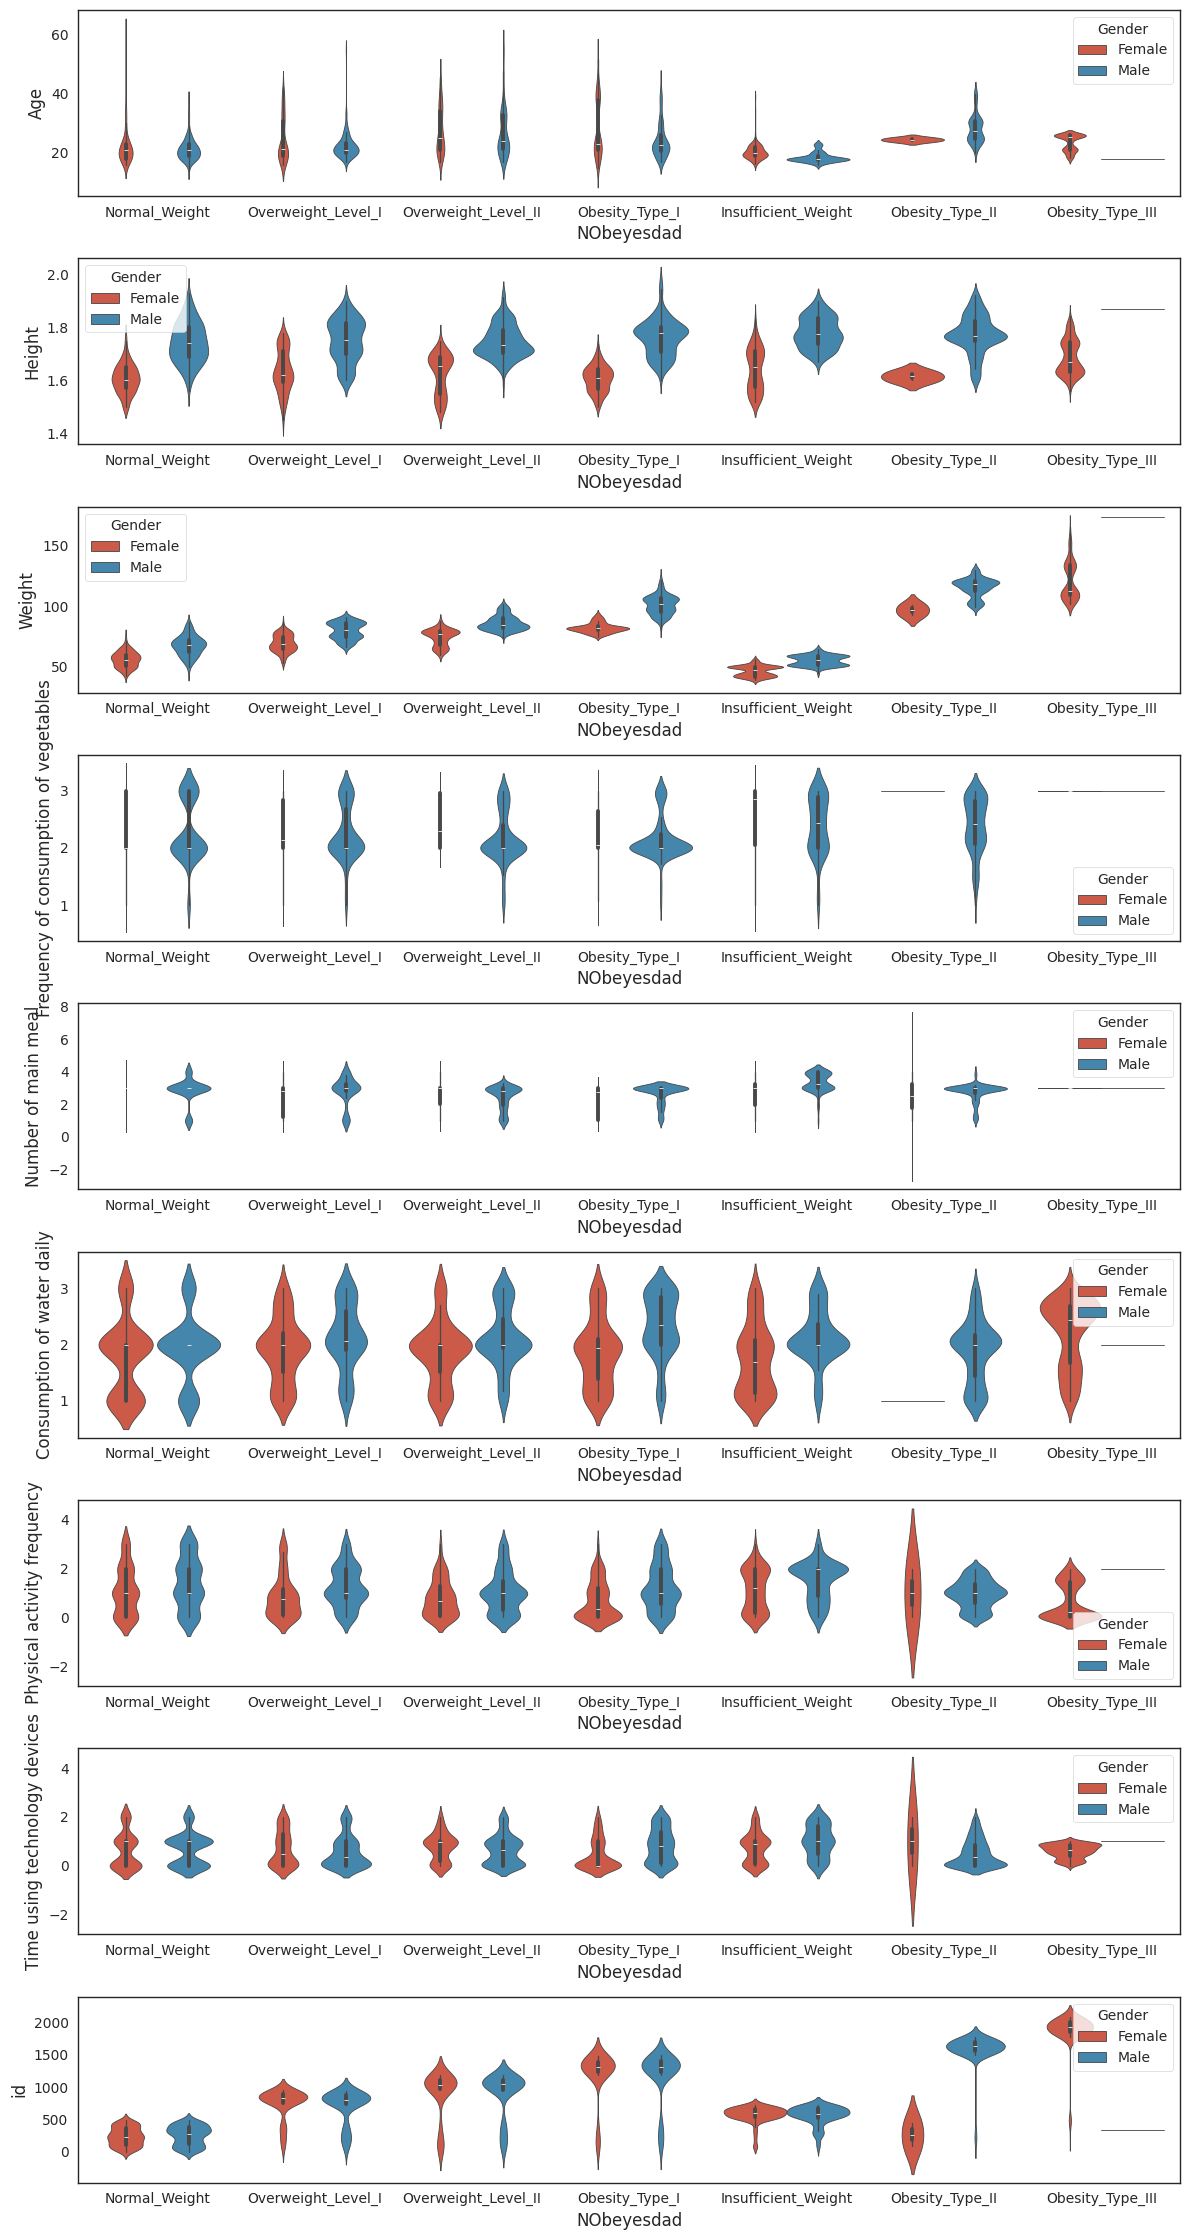

In [114]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)
for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=df,ax = axs[i], split=False)
    if col in full_form.keys():
        axs[i].set_ylabel(full_form[col])

plt.tight_layout()
plt.show()

## Individual Categorical Plots Plots

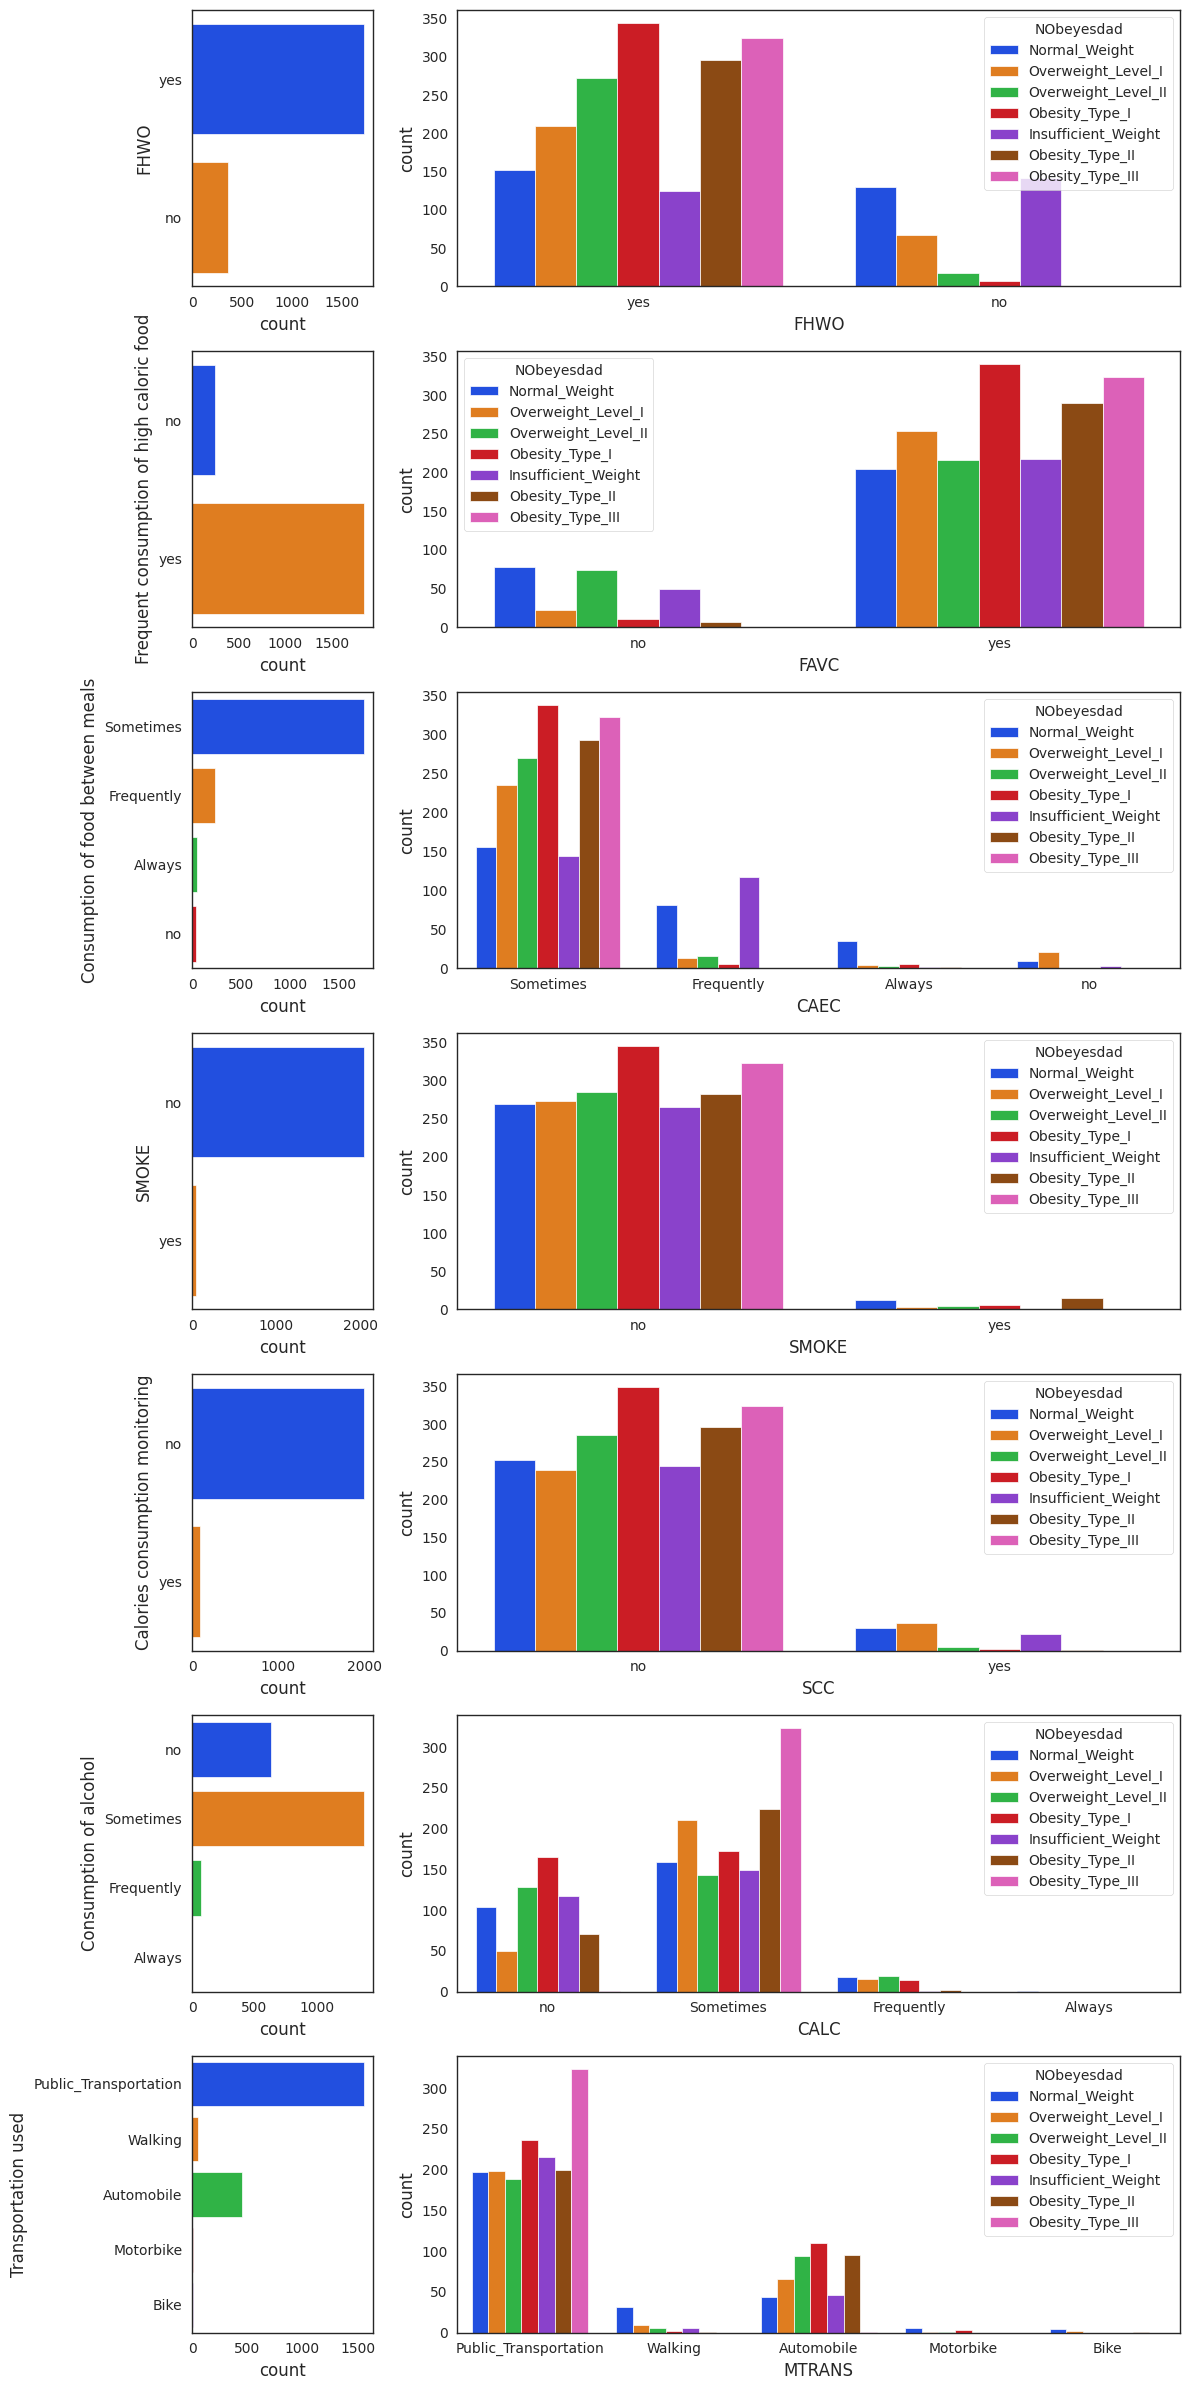

In [115]:
_,axs = plt.subplots(int(len(raw_cat_cols)-1),2,figsize=(12,len(raw_cat_cols)*3),width_ratios=[1, 4])
for i,col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col,data=df,palette="bright",ax=axs[i,0])
    sns.countplot(x=col,data=df,hue=TARGET,palette="bright",ax=axs[i,1])
    if col in full_form.keys():
        axs[i,0].set_ylabel(full_form[col])


plt.tight_layout()
plt.show()

## Numerical Correlation Plot

<Axes: >

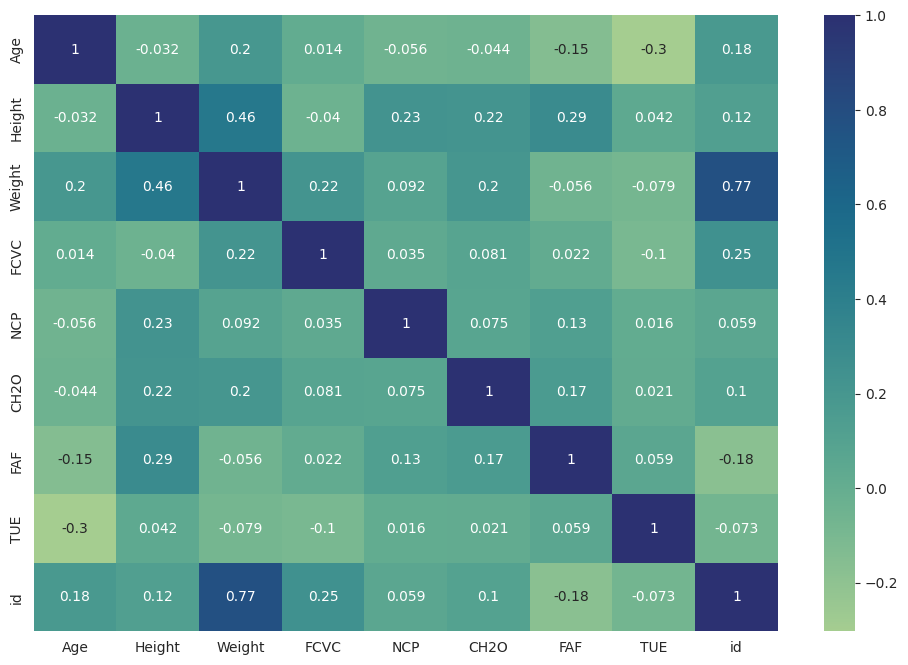

In [116]:
tmp = df[raw_num_cols].corr("pearson")
sns.heatmap(tmp,annot=True,cmap ="crest")

## Feature Engineering

1. **Body Mass Index (BMI):**

The initial step involved calculating the BMI using the 'Height' and 'Weight' features. BMI, a widely recognized metric, indicates obesity by providing a more accurate representation of the relationship between an individual's weight and height.

2. **Meal Habits:**

The combination of 'FCVC' (Frequency of consumption of vegetables) and 'NCP' (Number of main meals) created the 'Meal_Habits' feature. This feature seeks to encapsulate overall dietary patterns, considering both the frequency of vegetable consumption and the number of main meals.

3. **Tech Usage Score:**

A comprehensive score was crafted by weighting the frequency of technology usage ('TUE') by the individual's age. The resulting 'Tech_Usage_Score' aims to quantify the average time spent using technology relative to the person's age, providing a nuanced perspective on technology habits.

In [117]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['Meal_Habits'] = df['FCVC'] * df['NCP']
df['Tech_Usage_Score'] = df['TUE'] / df['Age']

In [118]:
print(f'{df[TARGET].value_counts()}\n\n')
print(df[TARGET].value_counts() / df[TARGET].shape[0])

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: NObeyesdad, dtype: int64


Obesity_Type_I        0.1682
Obesity_Type_III      0.1552
Obesity_Type_II       0.1423
Overweight_Level_II   0.1390
Normal_Weight         0.1351
Overweight_Level_I    0.1322
Insufficient_Weight   0.1279
Name: NObeyesdad, dtype: float64


# Label Encode & One Hot Encode

In [119]:
df_ordinal_columns = ["CAEC"]
df_nominal_columns = ["Gender","FHWO","FAVC", "SMOKE", "SCC", "CALC", "MTRANS"]

In [120]:
# Label Encoder untuk fitur kategorikal nominal
label_encoders = {}
for col in df_nominal_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [121]:
# Lakukan one-hot encoding
df_encoded = pd.get_dummies(df, columns = df_ordinal_columns)

In [122]:
df_encoded.drop(columns = "id", inplace = True)

# Modeling

In [123]:
X = df_encoded.drop(columns = TARGET)
y = df_encoded[TARGET]

In [124]:
y

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2087, dtype: object

In [125]:
# 1. Persiapan Dataset
# Misalkan kita memiliki dataset 'X' sebagai fitur dan 'y' sebagai target

# 2. Pembagian Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [126]:
# 4. Pipeline Model
classifiers = [
    ('Naive Bayes', GaussianNB()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier())
]

pipelines = []
for classifier_name, classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)  # Hanya model
    ])
    pipelines.append((classifier_name, pipeline))

In [127]:
# Definisikan parameter grid untuk setiap model
param_grid_nb = {
    'classifier__var_smoothing': [1e-9, 1e-7, 1e-5]
}

param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['linear', 'rbf']
}

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Buat dictionary yang berisi grid parameter untuk setiap model
param_grids = {
    'Naive Bayes': param_grid_nb,
    'SVM': param_grid_svm,
    'Decision Tree': param_grid_dt
}


Best_Params_Models = {}
# Lakukan hyperparameter tuning untuk setiap model
for classifier_name, pipeline in pipelines:
    param_grid = param_grids[classifier_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Tuned model terbaik
    best_estimator = grid_search.best_estimator_
    Best_Params_Models[classifier_name] = best_estimator

In [128]:
Best_Params_Models

{'Naive Bayes': Pipeline(steps=[('classifier', GaussianNB(var_smoothing=1e-05))]),
 'SVM': Pipeline(steps=[('classifier', SVC(C=0.1, kernel='linear'))]),
 'Decision Tree': Pipeline(steps=[('classifier', DecisionTreeClassifier(max_depth=20))])}

In [129]:
# Gabungkan model-model terbaik dalam satu pipeline
best_estimators = [(name, model) for name, model in Best_Params_Models.items()]

In [130]:
# 3. Pipeline Pra-Pemrosesan Data
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Mengisi nilai yang hilang dengan mean
    ('scaler', StandardScaler()),  # Penskalaan fitur menggunakan StandardScaler
    ('feature_selection', SelectKBest(score_func=f_classif, k=10))  # Seleksi 10 fitur terbaik
])

In [131]:
# 3. Pipeline Model
classifiers = [
    ('Naive Bayes', GaussianNB(var_smoothing=1e-07)),
    ('SVM', SVC(C=0.1, kernel='linear')),
    ('Decision Tree', DecisionTreeClassifier(max_depth=20))
]

pipelines = []
for classifier_name, classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)  # Hanya model
    ])
    pipelines.append((classifier_name, pipeline))

# 4. Pelatihan Model
for classifier_name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)


Evaluation Metrics for Naive Bayes:
Accuracy: 0.8301435406698564
Precision: 0.829769394761713
Recall: 0.8301435406698564
F1-score: 0.8268885981127782

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.82      0.98      0.89        56
      Normal_Weight       0.78      0.71      0.75        66
     Obesity_Type_I       0.84      0.74      0.79        70
    Obesity_Type_II       0.81      0.96      0.88        57
   Obesity_Type_III       1.00      0.99      0.99        68
 Overweight_Level_I       0.77      0.67      0.71        45
Overweight_Level_II       0.75      0.73      0.74        56

           accuracy                           0.83       418
          macro avg       0.82      0.83      0.82       418
       weighted avg       0.83      0.83      0.83       418



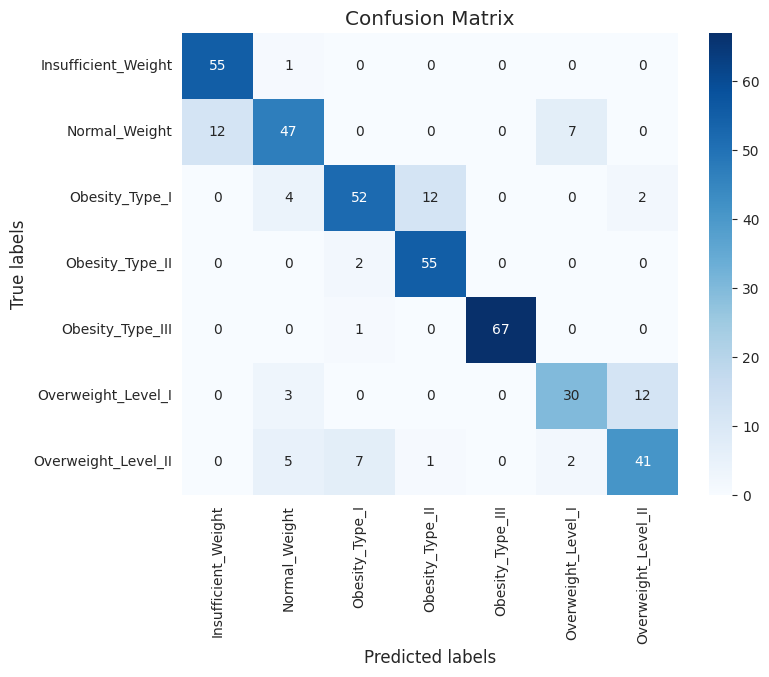


Evaluation Metrics for SVM:
Accuracy: 0.9712918660287081
Precision: 0.9713675814689366
Recall: 0.9712918660287081
F1-score: 0.9710853233830136

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.98      0.97        56
      Normal_Weight       0.98      0.97      0.98        66
     Obesity_Type_I       0.96      0.99      0.97        70
    Obesity_Type_II       0.98      1.00      0.99        57
   Obesity_Type_III       1.00      1.00      1.00        68
 Overweight_Level_I       0.93      0.96      0.95        45
Overweight_Level_II       0.96      0.89      0.93        56

           accuracy                           0.97       418
          macro avg       0.97      0.97      0.97       418
       weighted avg       0.97      0.97      0.97       418



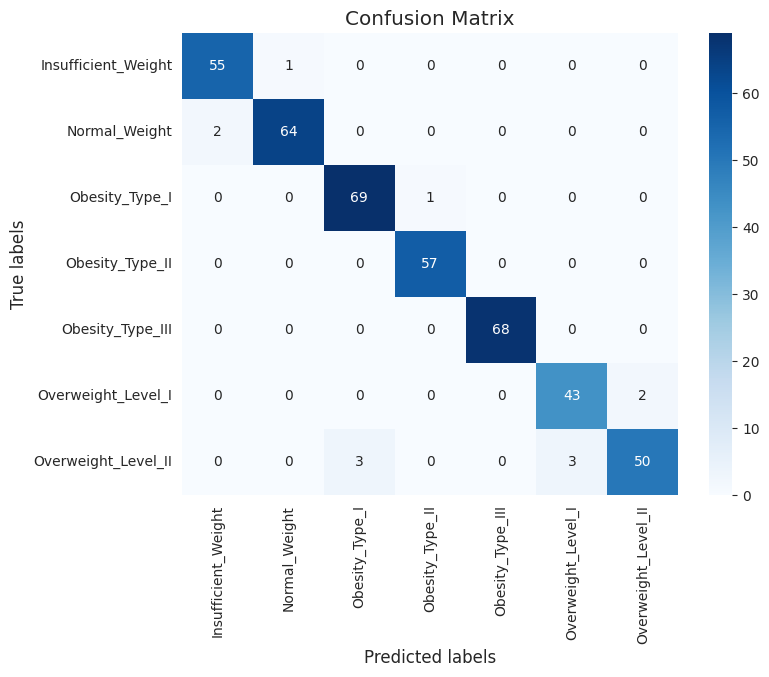


Evaluation Metrics for Decision Tree:
Accuracy: 0.9688995215311005
Precision: 0.969718866111509
Recall: 0.9688995215311005
F1-score: 0.9687909333138427

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        56
      Normal_Weight       0.98      0.98      0.98        66
     Obesity_Type_I       0.93      1.00      0.97        70
    Obesity_Type_II       1.00      0.93      0.96        57
   Obesity_Type_III       0.97      1.00      0.99        68
 Overweight_Level_I       0.93      0.96      0.95        45
Overweight_Level_II       0.96      0.91      0.94        56

           accuracy                           0.97       418
          macro avg       0.97      0.97      0.97       418
       weighted avg       0.97      0.97      0.97       418



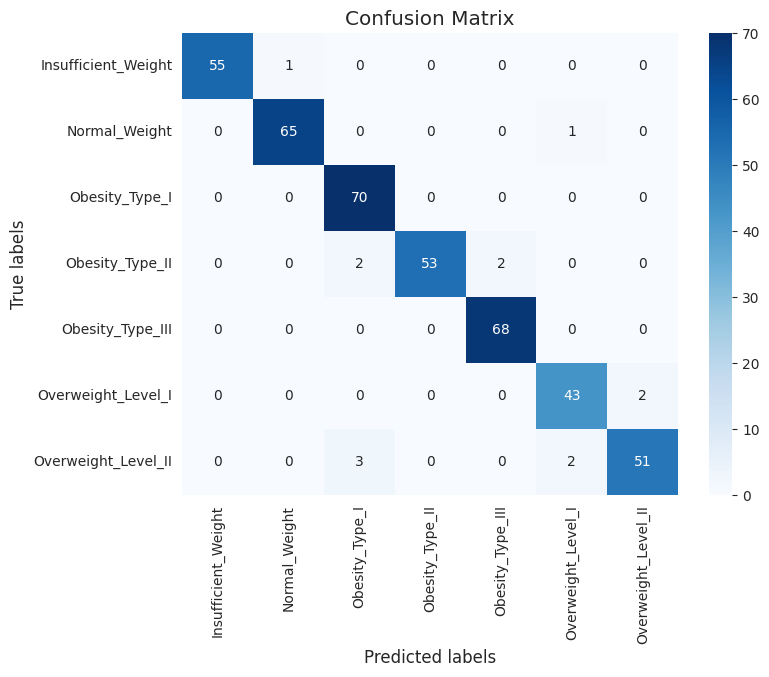

In [132]:
# Plot confusion matrix heatmap
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluasi model pada data uji
for classifier_name, pipeline in pipelines:
    y_pred = pipeline.predict(X_test)

    # Hitung metrik evaluasi tambahan
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Simpan metrik evaluasi dalam dictionary
    evaluation_metrics[classifier_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

    # Print hasil evaluasi
    print(f'\nEvaluation Metrics for {classifier_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    # Hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot heatmap untuk confusion matrix
    plot_confusion_matrix(cm, labels=['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II'])  # Sesuaikan dengan label kelas Anda

In [133]:
evaluation_metrics

{'Naive Bayes': {'Accuracy': 0.8301435406698564,
  'Precision': 0.829769394761713,
  'Recall': 0.8301435406698564,
  'F1-score': 0.8268885981127782},
 'SVM': {'Accuracy': 0.9712918660287081,
  'Precision': 0.9713675814689366,
  'Recall': 0.9712918660287081,
  'F1-score': 0.9710853233830136},
 'Decision Tree': {'Accuracy': 0.9688995215311005,
  'Precision': 0.969718866111509,
  'Recall': 0.9688995215311005,
  'F1-score': 0.9687909333138427}}

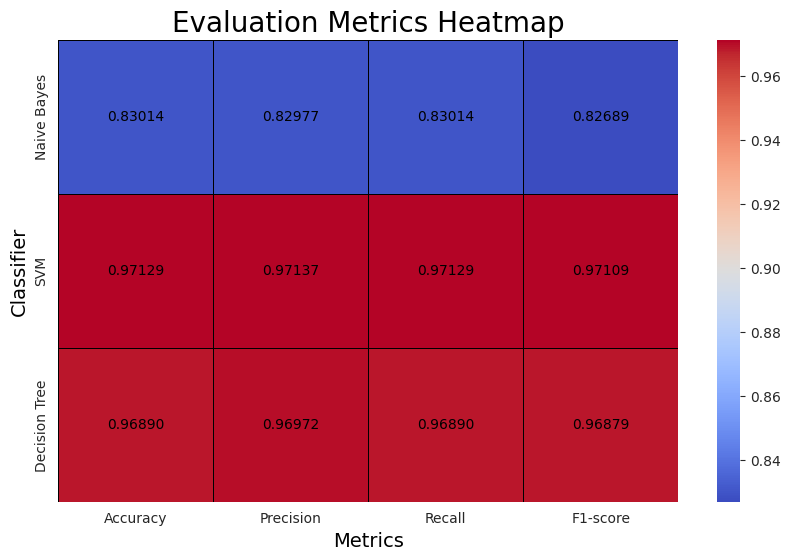

In [134]:
# Konversi dictionary evaluation_metrics ke dalam DataFrame
df_evaluation = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Plot heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_evaluation, annot=True, cmap='coolwarm', fmt=".5f", linewidths=0.5, linecolor='black')

# Atur properti label
heatmap.set_xlabel('Metrics', fontsize=14, color='black')
heatmap.set_ylabel('Classifier', fontsize=14, color='black')

# Atur properti teks annotasi
for text in heatmap.texts:
    text.set_color('black')

plt.title('Evaluation Metrics Heatmap', fontsize=20, color='black')
plt.show()


# Predicting to Data Test

In [135]:
Data_Test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Final Project [Enrollment]/TestDataSet.csv")

## Processing same with Data Train

In [136]:
Data_Test.rename(columns={"family_history_with_overweight":"FHWO"}, inplace = True)

In [137]:
Data_Test['BMI'] = Data_Test['Weight'] / (Data_Test['Height'] ** 2)
Data_Test['Meal_Habits'] = Data_Test['FCVC'] * Data_Test['NCP']
Data_Test['Tech_Usage_Score'] = Data_Test['TUE'] / Data_Test['Age']

In [138]:
Data_Test

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Meal_Habits,Tech_Usage_Score
0,20758,Male,26.8999,1.8483,120.6442,yes,yes,2.9386,3.0000,Sometimes,no,2.8256,no,0.8554,0.0000,Sometimes,Public_Transportation,35.3154,8.8158,0.0000
1,20759,Female,21.0000,1.6000,66.0000,yes,yes,2.0000,1.0000,Sometimes,no,3.0000,no,1.0000,0.0000,Sometimes,Public_Transportation,25.7812,2.0000,0.0000
2,20760,Female,26.0000,1.6434,111.6006,yes,yes,3.0000,3.0000,Sometimes,no,2.6219,no,0.0000,0.2505,Sometimes,Public_Transportation,41.3241,9.0000,0.0096
3,20761,Male,20.9793,1.5531,103.6691,yes,yes,2.0000,2.9779,Sometimes,no,2.7864,no,0.0949,0.0000,Sometimes,Public_Transportation,42.9769,5.9558,0.0000
4,20762,Female,26.0000,1.6274,104.8353,yes,yes,3.0000,3.0000,Sometimes,no,2.6535,no,0.0000,0.7411,Sometimes,Public_Transportation,39.5841,9.0000,0.0285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,Male,23.3278,1.7214,78.0304,yes,no,2.8132,3.0000,Sometimes,no,1.0000,no,0.8071,0.7786,Sometimes,Public_Transportation,26.3335,8.4397,0.0334
13836,34594,Female,29.0000,1.5900,62.0000,no,yes,3.0000,3.0000,Sometimes,no,2.0000,no,0.0000,0.0000,Sometimes,Public_Transportation,24.5243,9.0000,0.0000
13837,34595,Female,22.9356,1.5855,44.3766,no,yes,3.0000,2.2737,Frequently,no,2.0000,no,1.9498,1.0000,Sometimes,Public_Transportation,17.6521,6.8212,0.0436
13838,34596,Male,21.0000,1.6200,53.0000,yes,yes,2.0000,3.0000,Sometimes,no,2.0000,no,3.0000,2.0000,no,Public_Transportation,20.1951,6.0000,0.0952


In [139]:
# Label Encoder untuk fitur kategorikal nominal
label_encoders = {}
for col in df_nominal_columns:
    label_encoders[col] = LabelEncoder()
    Data_Test[col] = label_encoders[col].fit_transform(Data_Test[col])

In [140]:
# Lakukan one-hot encoding
Data_Test_encoded = pd.get_dummies(Data_Test, columns = df_ordinal_columns)

In [141]:
df_encoded.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'FHWO', 'FAVC', 'FCVC', 'NCP',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad',
       'BMI', 'Meal_Habits', 'Tech_Usage_Score', 'CAEC_Always',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no'],
      dtype='object')

In [142]:
# Misalkan kita ingin mengambil semua kolom kecuali kolom 'particular_column'
id = Data_Test_encoded["id"]
Data_Test_encoded = Data_Test_encoded.drop(columns=['id'])

In [143]:
# Evaluasi model pada data uji
for classifier_name, pipeline in pipelines:
    y_pred = pipeline.predict(Data_Test_encoded)
    print(y_pred)

['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Insufficient_Weight' 'Obesity_Type_II']
['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']
['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']


# Clustering with K-Means & DBScan

https://www.kaggle.com/code/jabirmuktabir/obesity-cvd-risk-clustering-with-k-means-bahasa

In [144]:
df_used_to_Cluster = df_encoded.drop(columns = TARGET)

## PCA (Principal Component Analysis)

In [145]:
from sklearn.decomposition import PCA  # Visualisasi Data Clustering

In [146]:
# Initialize the PCA model with the desired number of components
pca = PCA(n_components=.98)

# Fit and transform the data
transformed_data = pca.fit_transform(df_used_to_Cluster)

# Buat DataFrame dengan kolom PCA-1, PCA-2, dst.
column_names = [f'PCA-{i}' for i in range(1, transformed_data.shape[1] + 1)]
hasil_pca_sklearn = pd.DataFrame(data=transformed_data, columns=column_names)

In [147]:
hasil_pca_sklearn

,PCA-1,PCA-2,PCA-3
0,-23.5989,-2.1191,-1.5458
1,-31.2487,-1.7365,-3.0790
2,-11.1975,-1.1271,3.0384
3,-0.4935,2.1024,3.0971
4,2.2143,-2.4655,1.5801
...,...,...,...
2082,46.8118,-5.6346,-2.5022
2083,48.7812,-4.8652,-0.7469
2084,48.7018,-4.3440,-0.5250
2085,48.6155,-2.4740,-0.9864


In [148]:
explained_variances = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_variances)

# Total explained variance
total_explained_variance = sum(explained_variances)
print("Total explained variance:", total_explained_variance)

Explained variance ratios: [0.92915806 0.04957023 0.00947353]
Total explained variance: 0.9882018202412809


## Visualize Result PCA Before K-Means

### 2 Dimension

In [149]:
import plotly.express as px

# Ganti dengan skema warna yang Anda inginkan
new_color_scheme = ['#FFFFFF']  # Misalnya, skema warna Putih
fig = px.scatter(
    hasil_pca_sklearn,
    x='PCA-1',
    y='PCA-2',
    title='Scatter Plot result of PCA',
    labels={'PCA-1': 'Principal Component 1', 'PCA-2': 'Principal Component 2'},
    hover_data=hasil_pca_sklearn.columns,
    color_discrete_sequence=new_color_scheme  # Menggunakan skema warna yang telah Anda tentukan
)

fig.update_layout(template='plotly_dark')  # Mengatur mode gelap

fig.show()

### 3 Dimension

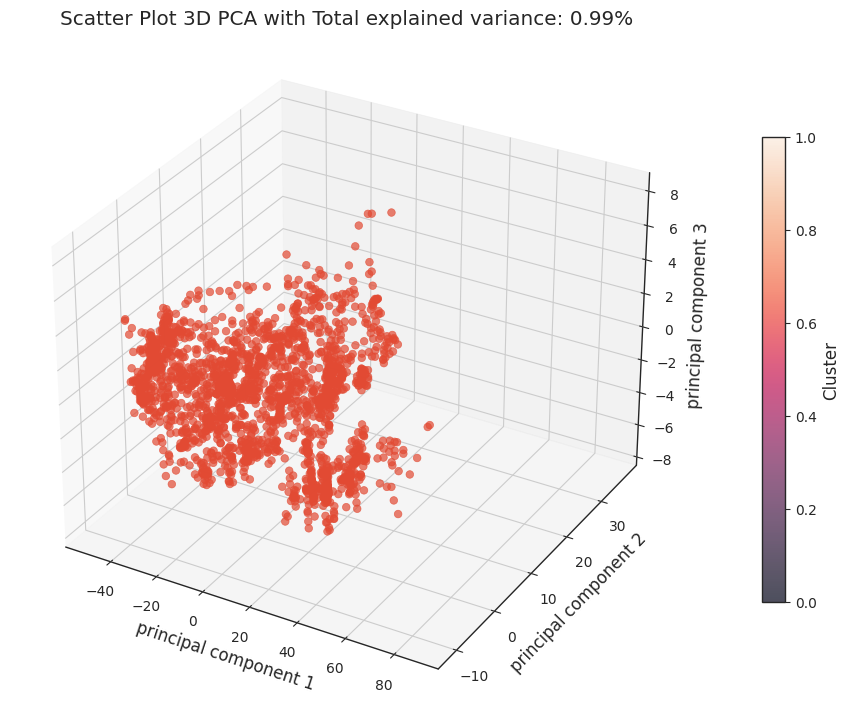

In [150]:
from mpl_toolkits.mplot3d import Axes3D

# Data
atribut1 = hasil_pca_sklearn['PCA-1']
atribut2 = hasil_pca_sklearn['PCA-2']
atribut3 = hasil_pca_sklearn['PCA-3']

# Membuat scatter plot 3D dengan Matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot dengan warna berdasarkan kluster
scatter = ax.scatter(atribut1, atribut2, atribut3, cmap='viridis', s=30, alpha=0.7)
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

# Menambahkan label pada sumbu-sumbu
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')
# Menambahkan judul
ax.set_title(f'Scatter Plot 3D PCA with Total explained variance: {round(total_explained_variance,2)}%')

# Set proporsi sumbu dengan penyesuaian tinggi
ax.set_box_aspect([1, 1, 0.8])  # [width, height, depth]

# Menambahkan colorbar dengan penyesuaian tinggi dan posisi
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.1, aspect=20)
cbar.set_label('Cluster')

# Menampilkan plot
plt.show()

## K-Means Algorithm

In [151]:
from sklearn.cluster import KMeans # Kmeans

from sklearn.preprocessing import MinMaxScaler, LabelEncoder #Scaling dan Normalisasi Data

from sklearn.metrics import davies_bouldin_score # Evaluasi Model Clustering
from sklearn.metrics import silhouette_score,silhouette_samples # Evaluasi Model Clustering

import matplotlib.cm as cm #Untuk Menampilkan Grafik

### Metode Siku (Elbow Methode)

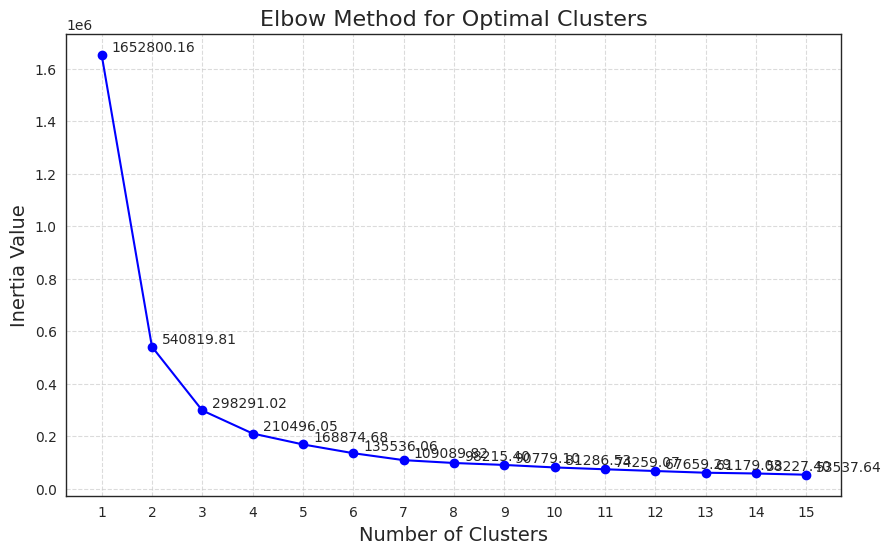

In [152]:
# Memilih Angka Optimal Untuk K (k)
# Menggunakan Metode Siku (Elbow Methode)
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(hasil_pca_sklearn)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method with Labels
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), wcss, marker='o', linestyle='-', color='b')

# Menambahkan label untuk setiap titik data
for i, inertia in enumerate(wcss):
    plt.text(i + 1.2, inertia, f'{inertia:.2f}', ha='left', va='bottom', fontsize=10)

plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia Value', fontsize=14)
plt.xticks(range(1, 16))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Differentiation in WCSS

In [153]:
result_diff_inersia = []
for i in range(1, len(wcss)):
    diff = wcss[i] - wcss[i - 1]
    result_diff_inersia.append(abs(diff))

In [154]:
# List untuk menyimpan hasil diff dan operasi pengurangan
diff_list = []
operation_list = []

# Loop untuk menghitung perbedaan dan operasi pengurangan
for i in range(1, len(wcss)):
    diff = wcss[i] - wcss[i - 1]
    diff_list.append(abs(diff))
    operation_list.append(f"{i} - {i - 1}")

# Membuat DataFrame dari hasil perhitungan
result_df = pd.DataFrame({'Diff': diff_list, 'Operation': operation_list}).sort_values(by="Diff", ascending=False)

# Mengubah nilai dalam kolom 'Operation'
result_df['Operation'] = result_df['Operation'].apply(lambda x: f"{int(x.split(' - ')[0]) + 1} - {int(x.split(' - ')[1]) + 1}")

In [155]:
result_df # Best Cluster for the K value is 3

,Diff,Operation
0,1111980.3484,2 - 1
1,242528.7888,3 - 2
2,87794.9695,4 - 3
3,41621.3705,5 - 4
4,33338.6226,6 - 5
5,26446.2411,7 - 6
6,10874.4224,8 - 7
8,9492.5753,10 - 9
7,7436.2934,9 - 8
9,7027.4589,11 - 10


### K-means with optimal n_cluster

In [156]:
# Apply K-means clustering
km_optimaze_k = KMeans(random_state = 70, n_clusters = 3, init = 'k-means++', n_init = 'auto', max_iter = 1000, tol = 0.0001)

In [157]:
km_optimaze_k.fit(hasil_pca_sklearn)

KMeans(max_iter=1000, n_clusters=3, n_init='auto', random_state=70)

In [158]:
predicted_labels = km_optimaze_k.labels_

#### Label Predict Counter

In [159]:
from collections import Counter
# Menggunakan Counter untuk menghitung kemunculan setiap nilai
label_counts = Counter(predicted_labels)
# Menampilkan hasil perhitungan
label_counts

Counter({2: 606, 0: 758, 1: 723})

In [160]:
import plotly.express as px

# Konversi data Counter ke DataFrame Pandas
labels, counts = zip(*label_counts.items())
df = pd.DataFrame({'Label': labels, 'Count': counts})

# Buat plot interaktif dengan plotly
fig = px.bar(df, x='Label', y='Count', text='Count', title='Count of Labels')
fig.update_traces(textposition='outside')
fig.show()

In [161]:
Final_data = hasil_pca_sklearn.copy()

In [162]:
Final_data['Cluster Result'] = predicted_labels

In [163]:
Final_data.sample(3)

,PCA-1,PCA-2,PCA-3,Cluster Result
687,-29.5276,-5.3590,4.5084,2
75,-43.7289,0.5467,0.8511,2
543,-36.4407,-6.3811,0.8159,2


### Visualize the Cluster Prediction

#### 2 Dimension

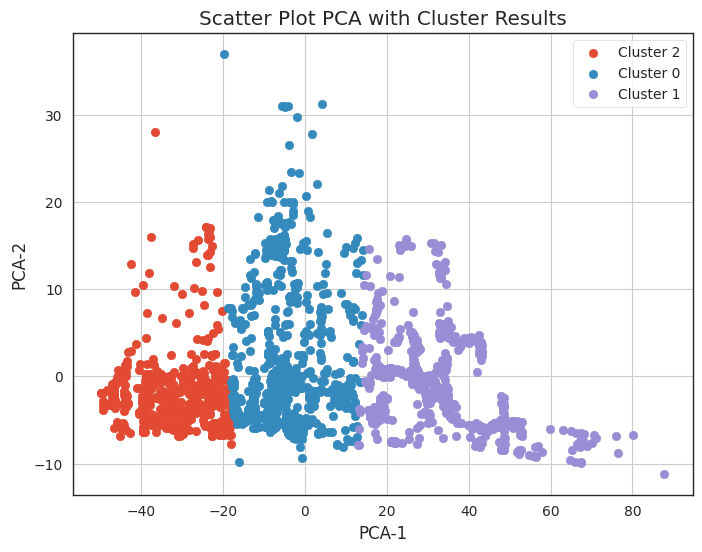

In [164]:
import matplotlib.pyplot as plt

# Buat scatter plot untuk PCA dengan memberikan warna sesuai dengan hasil klastering
plt.figure(figsize=(8, 6))
for cluster_label in Final_data['Cluster Result'].unique():
    plt.scatter(
        Final_data.loc[Final_data['Cluster Result'] == cluster_label, 'PCA-1'],
        Final_data.loc[Final_data['Cluster Result'] == cluster_label, 'PCA-2'],
        label=f'Cluster {cluster_label}'
    )

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Scatter Plot PCA with Cluster Results')
plt.legend()
plt.grid(True)
plt.show()

#### 3 Dimension

In [165]:
import plotly.express as px

# Data
atribut1 = Final_data['PCA-1']
atribut2 = Final_data['PCA-2']
atribut3 = Final_data['PCA-3']
cluster = Final_data['Cluster Result']

# Membuat DataFrame
df = pd.DataFrame({'PCA-1': atribut1, 'PCA-2': atribut2, 'PCA-3': atribut3, 'Cluster': cluster})

# Membuat scatter plot 3D dengan Plotly Express
fig = px.scatter_3d(df, x='PCA-1', y='PCA-2', z='PCA-3', color='Cluster',
                    title=f'Scatter Plot 3D PCA with Total explained variance: {round(total_explained_variance,2)}%',
                    labels={'PCA-1': 'principal component 1', 'PCA-2': 'principal component 2', 'PCA-3': 'principal component 3'},
                    opacity=0.7)

# Mengatur tata letak frame menjadi vertikal
fig.update_layout(width=800, height=800)

# Menampilkan plot
fig.show()


## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster

In [166]:
from sklearn.cluster import DBSCAN

In [167]:
# Membuat model DBSCAN
dbscan = DBSCAN()

In [168]:
# Melatih model
dbscan.fit(hasil_pca_sklearn) # [min_samples] default = 5; [eps] default=0.5

DBSCAN()

### Default Parameter DBSCAN

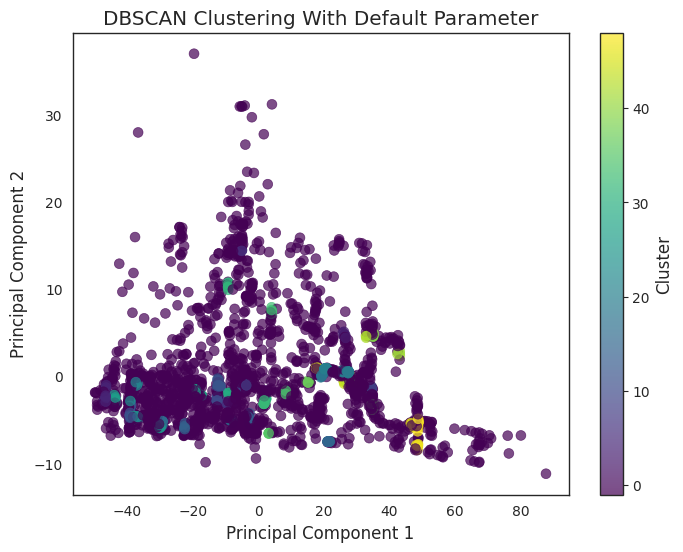

In [187]:
import matplotlib.pyplot as plt

# Plot hasil klastering
plt.figure(figsize=(8, 6))
plt.scatter(hasil_pca_sklearn.iloc[:, [0]], hasil_pca_sklearn.iloc[:, [1]], c=dbscan.labels_, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering With Default Parameter')
plt.colorbar(label='Cluster')
plt.show()

### Optimasi DBSCAN With K-Distance Graph Method

In [219]:
from sklearn.neighbors import NearestNeighbors

# Mencari jarak ke K-nearest neighbors untuk setiap titik data
k = 5 # Misalnya, kita akan mencari jarak ke 4 tetangga terdekat
nn = NearestNeighbors(n_neighbors=k)
nn.fit(hasil_pca_sklearn)
distances, indices = nn.kneighbors(hasil_pca_sklearn)

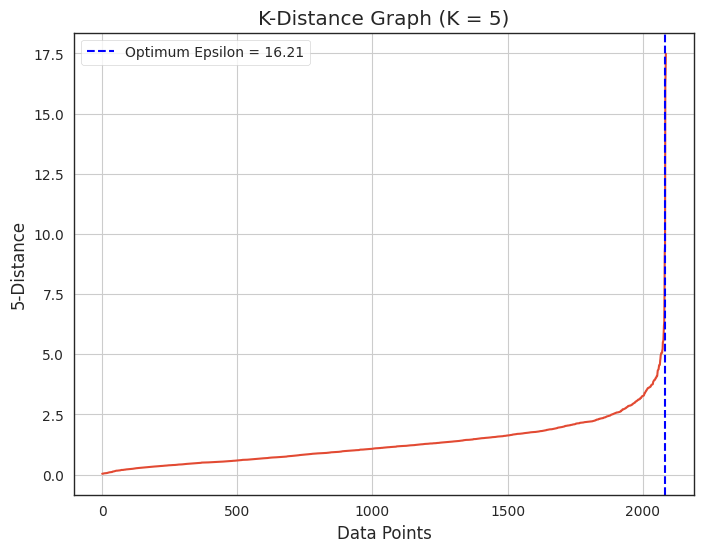

In [220]:
# Sort distances and plot K-distance graph
k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(X)), k_distances)
plt.xlabel('Data Points')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Graph (K = {k})')
plt.grid(True)

# Find the knee/elbow point
deltas = k_distances[1:] - k_distances[:-1]
knee_index = np.argmax(deltas) + 1
epsilon = k_distances[knee_index]

# Highlight the knee/elbow point
plt.axvline(x=knee_index, color='b', linestyle='--', label=f'Optimum Epsilon = {epsilon:.2f}')
plt.legend()

plt.show()

### DBSCAN with Optimasi Epsilon

In [235]:
# Membuat model DBSCAN
dbscan_opt = DBSCAN(eps=epsilon, min_samples=8)

In [236]:
# Melatih model
dbscan_opt.fit(hasil_pca_sklearn)

DBSCAN(eps=16.21478120825516, min_samples=8)

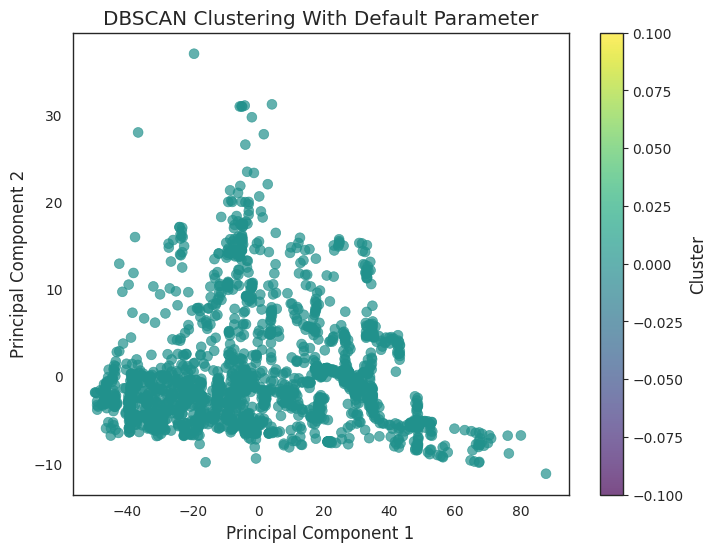

In [237]:
import matplotlib.pyplot as plt

# Plot hasil klastering
plt.figure(figsize=(8, 6))
plt.scatter(hasil_pca_sklearn.iloc[:, [0]], hasil_pca_sklearn.iloc[:, [1]], c=dbscan_opt.labels_, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering With Default Parameter')
plt.colorbar(label='Cluster')
plt.show()

### Now with Tuning Parameter

In [227]:
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [243]:
# 1. Analisis Klaster
# Prediksi klaster untuk setiap titik data
labels = dbscan.labels_

# 2. Tuning Parameter
# Lakukan tuning parameter dengan mencoba berbagai nilai eps dan min_samples
eps_values = [i for i in range(1, 15)]
min_samples_values = [i for i in range(1, 15)]

best_score = -1
best_eps = None
best_min_samples = None
best_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        # Inisialisasi dan latih model DBSCAN dengan parameter yang diuji
        dbscan_tuned = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_tuned.fit(hasil_pca_sklearn)

        # Evaluasi model menggunakan indeks siluet
        sil_score = silhouette_score(hasil_pca_sklearn, dbscan_tuned.labels_)

        # Pilih parameter dengan skor siluet tertinggi
        if sil_score > best_score:
            best_score = sil_score
            best_eps = eps
            best_min_samples = min_samples
            best_labels = dbscan_tuned.labels_

# 3. Analisis dan Interpretasi
# Lakukan analisis lebih lanjut terhadap klaster yang dihasilkan
# Misalnya, hitung jumlah dan proporsi titik data dalam setiap klaster
unique_clusters = np.unique(best_labels)
cluster_counts = {cluster: np.sum(best_labels == cluster) for cluster in unique_clusters}
total_points = len(best_labels)
cluster_proportions = {cluster: count / total_points for cluster, count in cluster_counts.items()}

# 4. Validasi
# Validasi hasil klaster menggunakan metrik evaluasi
# Misalnya, indeks siluet
silhouette_avg = silhouette_score(hasil_pca_sklearn, best_labels)
print(f"Silhouette Score: {silhouette_avg}")

# 5. Interpretasi Hasil
# Interpretasikan hasil klaster dalam konteks masalah yang sedang dihadapi
# Identifikasi klaster yang memiliki makna bisnis yang penting
# dan tindakan atau keputusan yang dapat diambil berdasarkan hasil klastering

# Output hasil tuning parameter
print(f"Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}")

# Output analisis hasil klaster
print("Cluster Analysis:")
for cluster, count in cluster_counts.items():
    proportion = cluster_proportions[cluster]
    print(f"Cluster {cluster}: {count} points ({proportion:.2%} of total)")

# Output siluet score
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.49916845395448217
Best Parameters - eps: 7, min_samples: 7
Cluster Analysis:
Cluster -1: 4 points (0.19% of total)
Cluster 0: 2083 points (99.81% of total)
Silhouette Score: 0.49916845395448217


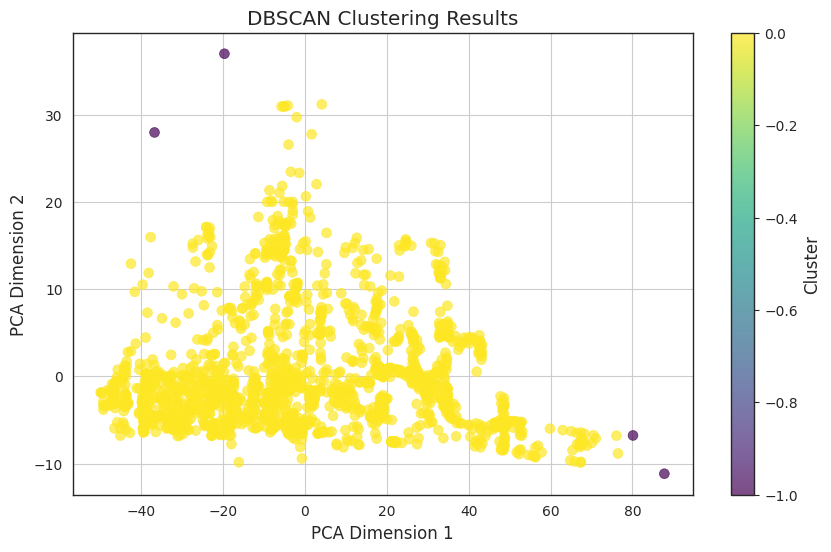

In [245]:
# Plot hasil klaster menggunakan dimensi hasil PCA
plt.figure(figsize=(10, 6))
plt.scatter(hasil_pca_sklearn.iloc[:, 0], hasil_pca_sklearn.iloc[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()
